<a href="https://colab.research.google.com/github/alex-hse-repository/Information_System/blob/main/%D0%98%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

from scipy.stats import expon
from scipy.stats import chisquare

# Класс симмуляционной модели

In [11]:
class Statistics:
    def __init__(self, N, k):
        self.utilization = 0
        self.utilizations = np.zeros(N)
        
        self.lost_customers = np.zeros(k,dtype=int)
        self.served_customers = np.zeros(k,dtype=int)
        self.cutomers_num = 0

        self.lost_probs = np.zeros(k)
        self.destribution = {}

        self.arrivals = [[],[],[]]
        self.intervals = [[],[],[]]

        
    def lose(self,client_type):
        self.lost_customers[client_type]+=1
    def serve(self,client_type):
        self.served_customers[client_type]+=1 
    def arrive(self,client_type,time):
        self.arrivals[client_type].append(time)
        self.arrivals[-1].append(time)      

    def count_stats(self,duaration):
        #self.utilisations = np.sum(self.service_times,axis=1)/duaration
        #self.utilization = np.mean(self.utilizations)
        #self.cutomers_num = np.sum(self.lost_customers)+np.sum(np.sum(self.served_customers))

        #Расчет интервалов прибытия
        for i in range(3): 
            self.intervals[i] = np.array(self.arrivals[i])[1:]-np.array(self.arrivals[i])[:-1]
        
        #Расчет вероятностей потерь
        self.cutomers_num = self.lost_customers+self.served_customers
        self.lost_probs = self.lost_customers/self.cutomers_num

        #Нормализация распределения
        total = 0
        for state in self.destribution:
            total+=self.destribution[state]
        for state in self.destribution:
            self.destribution[state]/=total

    def update_destribution(self,cur_state):
        if(cur_state in self.destribution):
            self.destribution[cur_state]+=1
        else:
            self.destribution[cur_state]=1

In [57]:
class Simulation:
    def __init__(self,N,g,lambdas,mus,duaration):
        self.N = N
        self.g = g
        self.k = len(mus)
        self.stats = Statistics(N,self.k)
        self.clock = 0.0
        self.duaration = duaration
        self.reserved = N-g
        self.lambdas = lambdas
        self.mus = mus
        self.X = np.zeros(self.k,dtype=int)
        self.arrival_evt = self.gen_arrival()
        self.servers = np.array([{'client_type':-1,'time':np.inf} for _ in range(N)])

    def arrival(self):
        client_type = self.arrival_evt['client_type']
        time = self.arrival_evt['time']
        self.stats.arrive(client_type,time)
        if(self.arrival_is_possible(client_type)):
            self.stats.serve(client_type)
            server_id = self.get_server()
            self.X[client_type]+=1
            self.servers[server_id] = {'client_type':client_type,'time':self.gen_departure(client_type)}
        else:
            self.stats.lose(client_type)
        self.arrival_evt = self.gen_arrival()
    
    def departure(self,server_id):
        client_type = self.servers[server_id]['client_type']
        self.X[client_type]-=1
        self.servers[server_id] = {'client_type':-1,'time':np.inf}        

    def arrival_is_possible(self,client_type):
        free = self.N-np.sum(self.X)
        if(client_type==0):
            return free>self.reserved
        return free>0    
    def get_server(self):
        for server_id in range(self.N):
            if(self.servers[server_id]['client_type']==-1):
                return server_id

    def gen_arrival(self):
        times = self.clock+np.random.exponential(self.lambdas,size=len(self.lambdas))
        client_type = np.argmin(times)
        time = times[client_type]
        return {'client_type':client_type,'time':time}
    def gen_departure(self,client_type):
        time = self.clock+np.random.exponential(self.mus[client_type])
        return time    

    def next_arrival(self):
        return self.arrival_evt
    def next_departure(self):
        best = 0
        for server_id in range(self.N):
            time = self.servers[server_id]['time'] 
            min_time = self.servers[best]['time']
            if(time<min_time):
                best = server_id
        return {'server_id':best,'time':self.servers[best]['time']}
    def next_event(self):  
        arrival_evt = self.next_arrival()
        departure_evt = self.next_departure()                                              
        self.clock = min(arrival_evt['time'],departure_evt['time'])    
        if(arrival_evt['time']<departure_evt['time']):
            self.arrival()
        else:
            self.departure(departure_evt['server_id'])
             
    def run(self):
        print('Simulation for N = {}, g = {}:'.format(self.N,self.g))
        t = 1
        while(self.clock<self.duaration):
            self.next_event()
            if(self.clock>t*10):
                t+=1
                print('cur_time: ',self.clock)
            cur_state = str(self.X)[1:-1] 
            self.stats.update_destribution(cur_state)
        self.stats.count_stats(duaration)


* Симуляция

In [58]:
N = 100 # Количество серверов
gs = [10,20,50,80,100] # Количество полнодоступных серверов
lambdas = 1/np.array([1000,500]) # Парамтры входных потоков
mus = 1/np.array([10,15]) # Параметры выходных потоков
duaration = 100 # Длительность симуляциии
probs = {'B1':[],'B2':[],'B':[]} # Вероятности потери клиентов
for g in gs:
    sim = Simulation(N,g,lambdas,mus,duaration)
    sim.run()
    prob = sim.stats.lost_probs
    probs['B1'].append(prob[0])
    probs['B2'].append(prob[1])
    probs['B'].append(np.sum(prob))

Simulation for N = 100, g = 10:
cur_time:  10.000089707161505
cur_time:  20.000960748580518


KeyboardInterrupt: ignored

* Оценка вероятностей потерь

In [18]:
data = pd.DataFrame(probs)
data

,B1,B2,B
0,0.999960,0.000000,0.999960
1,0.999927,0.000000,0.999927
2,0.958099,0.000000,0.958099
3,0.772778,0.000041,0.772819
4,0.479164,0.478861,0.958025


* Отрисовка распределения

{'0 1': 3.0733957642459576e-06, '1 1': 3.0733957642459576e-06, '1 0': 3.0733957642459576e-06, '2 0': 3.0733957642459576e-06, '3 0': 3.0733957642459576e-06, '4 0': 3.0733957642459576e-06, '5 0': 3.0733957642459576e-06, '6 0': 3.0733957642459576e-06, '7 0': 3.0733957642459576e-06, '8 0': 3.0733957642459576e-06, '8 1': 3.0733957642459576e-06, '9 1': 3.0733957642459576e-06, '10  1': 3.0733957642459576e-06, '11  1': 6.146791528491915e-06, '12  1': 9.220187292737873e-06, '13  1': 3.0733957642459576e-06, '12  2': 3.0733957642459576e-06, '13  2': 6.146791528491915e-06, '14  2': 3.0733957642459576e-06, '13  3': 6.146791528491915e-06, '12  3': 3.0733957642459576e-06, '13  4': 3.0733957642459576e-06, '13  5': 3.0733957642459576e-06, '14  5': 3.0733957642459576e-06, '15  5': 3.0733957642459576e-06, '15  6': 3.0733957642459576e-06, '15  7': 9.220187292737873e-06, '15  8': 3.0733957642459576e-06, '14  7': 3.0733957642459576e-06, '16  7': 3.0733957642459576e-06, '17  7': 3.0733957642459576e-06, '18  

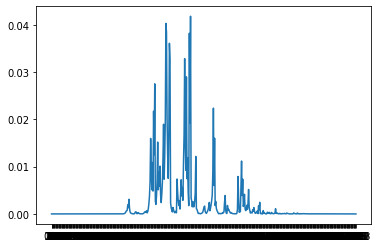

In [20]:
probs = sim.stats.destribution
x = [key for key in probs]
y = [probs[key] for key in probs]
prob = np.sum(y)
plt.plot([key for key in probs],[probs[key] for key in probs])
print(probs)

* Тестовые симуляции

In [59]:
N = 100 # Количество серверов
gs = [80] # Количество полнодоступных серверов
lambdas = 1/np.array([1000,500]) # Парамтры входных потоков
mus = 1/np.array([10,15]) # Параметры выходных потоков
duaration = 100 # Длительность симуляциии
probs = {'B1':[],'B2':[],'B':[]} # Вероятности потери клиентов
for g in gs:
    sim = Simulation(N,g,lambdas,mus,duaration)
    sim.run()
    prob = sim.stats.lost_probs
    probs['B1'].append(prob[0])
    probs['B2'].append(prob[1])
    probs['B'].append(np.sum(prob))

Simulation for N = 100, g = 80:
cur_time:  10.00027017002138
cur_time:  20.000107559248992
cur_time:  30.00040935329049
cur_time:  40.0009507143839
cur_time:  50.00059659293956
cur_time:  60.00019229334991
cur_time:  70.00051971347249
cur_time:  80.00001814564312
cur_time:  90.00011303588624
cur_time:  100.00073680427708


In [61]:
B1 = 0
for i in range(gs[0]+1):
    j = 100-i
    state = str(i)+" "+str(j)
    if(state in sim.stats.destribution):
        B1+=sim.stats.destribution[state]
for j in range(N-gs[0]):
    i = gs[0]
    state = str(i)+" "+str(j)
    if(state in sim.stats.destribution):
        B1+=sim.stats.destribution[state]
B1    

0

In [62]:
data = pd.DataFrame(probs)
data

,B1,B2,B
0,0.537074,0.0,0.537074


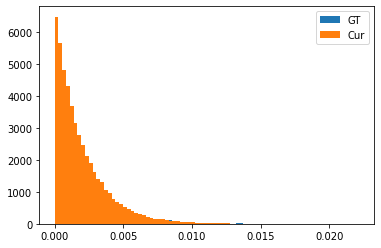

In [63]:
Y = sim.stats.intervals[1]
#X = np.random.exponential(1/(np.sum(1/lambdas)),size = len(Y),)
X = np.random.exponential(lambdas[1],size = len(Y),)
plt.hist(X,bins=80,label = 'GT');
plt.hist(Y,bins=80,label = 'Cur');
plt.legend()

In [68]:
1/np.mean(sim.stats.intervals[0])

999.8922384266916

In [69]:
1/np.mean(sim.stats.intervals[1])

500.0720314598552

In [70]:
1/np.mean(sim.stats.intervals[2])

1499.9533578974847

* Тест на распределение

In [87]:
lambda_true = 500

In [88]:
def F(x):
    # Функция распределения
    return expon.cdf(x,scale=1/lambda_true)

In [89]:
def get_Expectations(sep_points,n):
    # n - Размер выборки 
    # Расчет ожидаемых частот
    k_folds = len(sep_points)-1
    p = np.zeros(k_folds) # Распределение на бинах
    for i in range(k_folds):
        if(i==0):
            p[i] = F(sep_points[1])
        elif(i==k_folds-1):
            p[i] = 1-F(sep_points[i-1])
        else:
            p[i] = F(sep_points[i+1])-F(sep_points[i]) 
    return n*p              

In [91]:
k_folds = 80
X = sim.stats.intervals[1]
sep_points = np.linspace(np.min(X),np.max(X),num=k_folds+1) # Разбиение области значений на k_folds отрезков
O = np.zeros(k_folds) # Наблюдаемые частоты
for i in range(k_folds):
    O[i] = len(X[X<sep_points[i+1]])-len(X[X<sep_points[i]])  
# Ожидаемые частоты для разных оценок    
E = get_Expectations(sep_points,len(X))
Q,p = chisquare(O,E)
print('Значение статистики и p_value: ')
print('Q = ',Q,'p_value = ',p)

Значение статистики и p_value: 
Q =  76.9556337275443 p_value =  0.5441448398338251
